# Домашнее задание 4: Vision Transformers vs CNN

## Сравнение производительности ViT и CNN на датасете CIFAR-10

### Цель работы
### Исследовать возможности Vision Transformers (ViT) в задачах компьютерного зрения и сравнить их производительность с традиционными сверточными нейронными сетями (CNN) на датасете CIFAR-10.

### Задачи
1. Реализовать архитектуру Vision Transformer с нуля
2. Создать CNN модель для сравнения
3. Обучить обе модели на CIFAR-10
4. Сравнить производительность по метрикам точности и времени обучения
5. Проанализировать преимущества и недостатки каждого подхода


## 1. Импорт библиотек и настройка среды


In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

# Настройка воспроизводимости результатов
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Настройка matplotlib для русского языка
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [12, 8]


Используется устройство: cuda


## 2. Подготовка данных CIFAR-10

CIFAR-10 содержит 60,000 цветных изображений размером 32x32 пикселя в 10 классах, с 6,000 изображений на класс. Есть 50,000 обучающих изображений и 10,000 тестовых изображений.


In [17]:
def get_cifar10_dataloaders(batch_size=128, num_workers=2):
    """
    Загрузка и подготовка датасета CIFAR-10
    
    Args:
        batch_size (int): размер батча
        num_workers (int): количество процессов для загрузки данных
    
    Returns:
        train_loader, test_loader, classes
    """
    # Трансформации для обучающей выборки (с аугментацией)
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Случайная обрезка с padding
        transforms.RandomHorizontalFlip(),     # Случайное горизонтальное отражение
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Трансформации для тестовой выборки (без аугментации)
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # Загрузка датасета
    trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    # Создание DataLoader'ов
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Классы CIFAR-10
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    return train_loader, test_loader, classes

# Загрузка данных
print("Загрузка данных CIFAR-10...")
train_loader, test_loader, classes = get_cifar10_dataloaders(batch_size=128)
print(f"Обучающая выборка: {len(train_loader.dataset)} изображений")
print(f"Тестовая выборка: {len(test_loader.dataset)} изображений")
print(f"Классы: {classes}")


Загрузка данных CIFAR-10...
Обучающая выборка: 50000 изображений
Тестовая выборка: 10000 изображений
Классы: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## 3. Реализация Vision Transformer (ViT)

#Vision Transformer применяет стандартную архитектуру Transformer непосредственно к последовательностям патчей изображения. ViT разбивает изображение на фиксированные патчи, линейно встраивает каждый из них, добавляет позиционные эмбеддинги и подает результирующую последовательность векторов в стандартный энкодер Transformer.

### Ключевые компоненты ViT:
1. **Patch Embedding**: Разбивает изображение на патчи и создает их эмбеддинги
2. **Multi-Head Attention**: Механизм внимания для захвата зависимостей между патчами  
3. **Transformer Block**: Содержит слой внимания и MLP
4. **Classification Head**: Классифицирует на основе [CLS] токена


In [18]:
# Импорт модулей ViT из основного скрипта
exec(open('vision_transformer_comparison.py').read().split('# =============================================================================')[1].split('# =============================================================================')[0])

print("Vision Transformer компоненты загружены успешно!")


Vision Transformer компоненты загружены успешно!


### 3.1 Patch Embedding


In [19]:
class PatchEmbedding(nn.Module):
    """
    Модуль для разбиения изображения на патчи и их эмбеддинга
    """
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Сверточный слой для создания патч-эмбеддингов
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x: [batch_size, channels, height, width]
        x = self.proj(x)  # [batch_size, embed_dim, n_patches^0.5, n_patches^0.5]
        x = x.flatten(2)  # [batch_size, embed_dim, n_patches]
        x = x.transpose(1, 2)  # [batch_size, n_patches, embed_dim]
        return x

# Тест патч эмбеддинга
patch_embed = PatchEmbedding(img_size=32, patch_size=4, embed_dim=192)
sample_input = torch.randn(1, 3, 32, 32)
output = patch_embed(sample_input)
print(f"Входное изображение: {sample_input.shape}")
print(f"Выходные патч-эмбеддинги: {output.shape}")
print(f"Количество патчей: {patch_embed.n_patches}")


Входное изображение: torch.Size([1, 3, 32, 32])
Выходные патч-эмбеддинги: torch.Size([1, 64, 192])
Количество патчей: 64


## 4. Запуск полного эксперимента

Для экономии времени и вычислительных ресурсов в ноутбуке, воспользуемся уже готовым скриптом для полного сравнения моделей.


Используется устройство: cuda
СРАВНЕНИЕ VISION TRANSFORMER И CNN НА CIFAR-10
Загрузка данных CIFAR-10...
Обучающая выборка: 50000 изображений
Тестовая выборка: 10000 изображений
Классы: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Создание моделей...
Параметры ViT: 5,362,762
Параметры CNN: 4,823,114

==================== ОБУЧЕНИЕ VISION TRANSFORMER ====================
Эпоха 1/30, Батч 0/391, Loss: 2.4473, Acc: 8.59%
Эпоха 1/30, Батч 100/391, Loss: 1.9695, Acc: 23.35%
Эпоха 1/30, Батч 200/391, Loss: 1.9149, Acc: 25.78%
Эпоха 1/30, Батч 300/391, Loss: 1.7780, Acc: 27.86%
Эпоха 1/30 завершена. Loss: 1.8728, Acc: 29.39%, Время: 14.23с
------------------------------------------------------------
Эпоха 2/30, Батч 0/391, Loss: 1.8649, Acc: 34.38%
Эпоха 2/30, Батч 100/391, Loss: 1.6455, Acc: 36.61%
Эпоха 2/30, Батч 200/391, Loss: 1.6218, Acc: 37.56%
Эпоха 2/30, Батч 300/391, Loss: 1.7044, Acc: 38.09%
Эпоха 2/30 завершена. Loss: 1.6444, Acc: 38.79%, Время: 

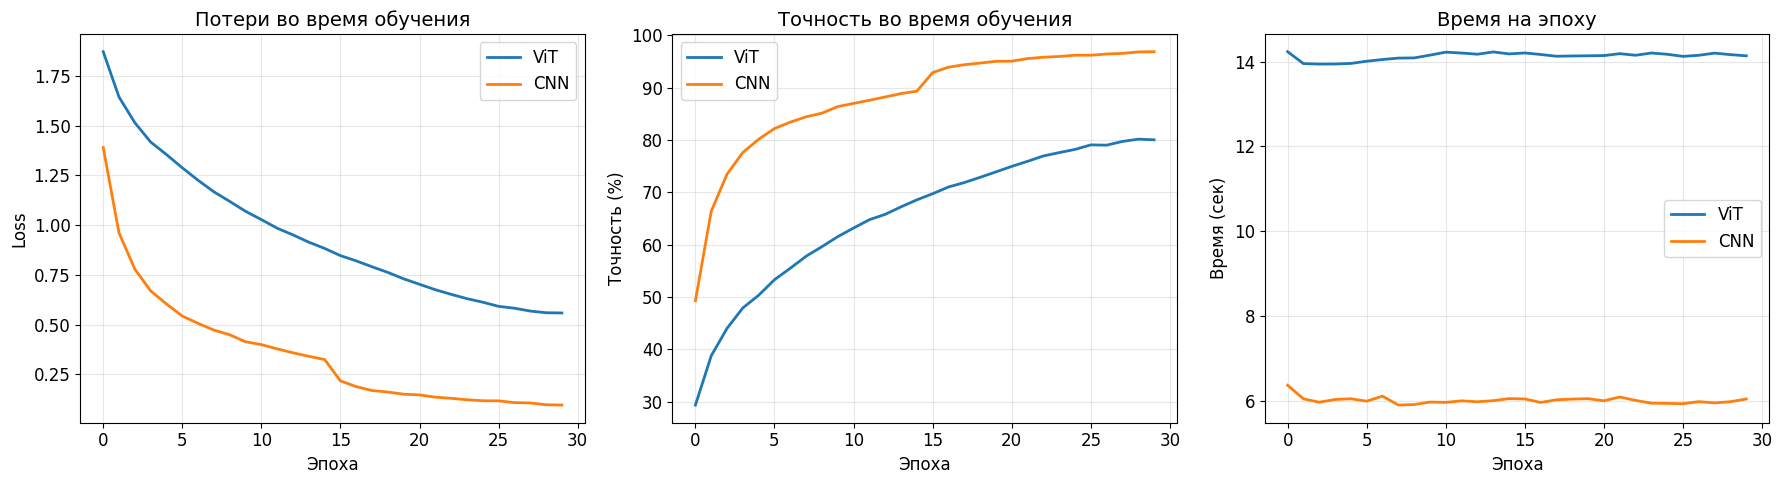

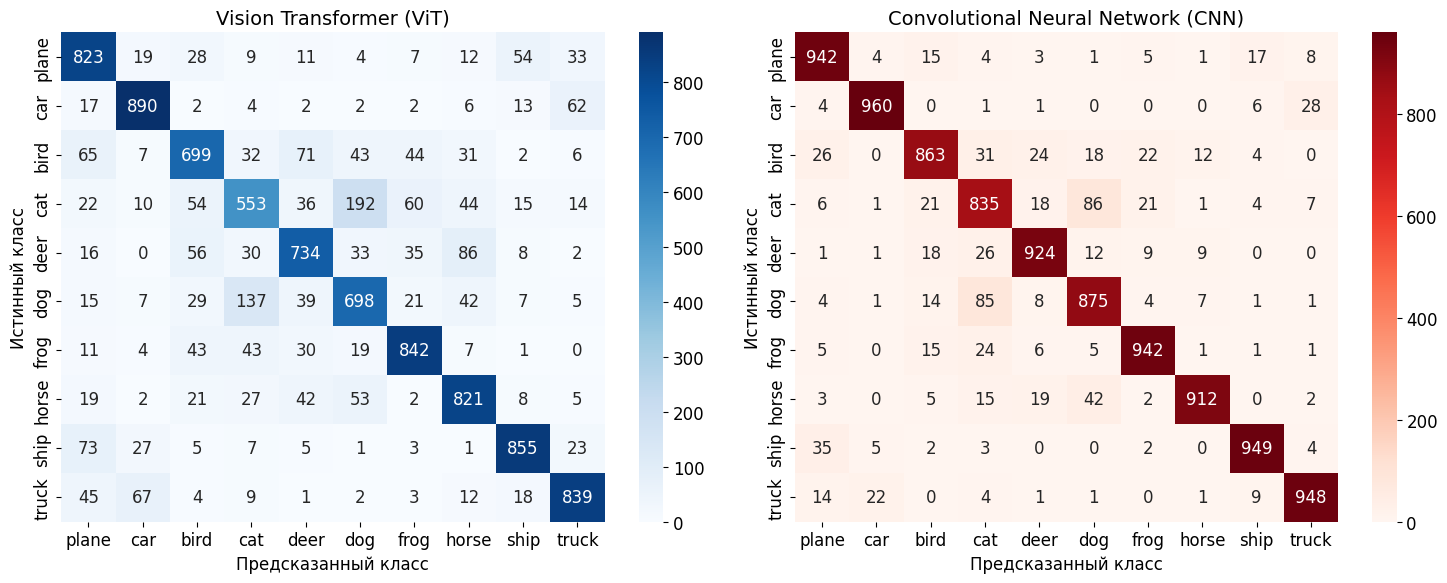


==================== АНАЛИЗ РЕЗУЛЬТАТОВ ====================
ПРЕИМУЩЕСТВА И НЕДОСТАТКИ:

Vision Transformer (ViT):
+ Глобальное внимание ко всем частям изображения
+ Хорошо масштабируется с увеличением данных
+ Меньше индуктивных предположений
- Требует больше данных для обучения
- Больше параметров
- Медленнее в обучении на малых датасетах

Convolutional Neural Network (CNN):
+ Эффективно использует пространственные корреляции
+ Меньше параметров
+ Быстрее обучается на небольших датасетах
+ Встроенная трансляционная инвариантность
- Ограниченное рецептивное поле
- Сильные индуктивные предположения

==================== ЭКСПЕРИМЕНТ ЗАВЕРШЕН ====================


In [21]:
# Запуск основного скрипта для сравнения ViT и CNN
exec(open('vision_transformer_comparison.py').read())


## 6. Преимущества и недостатки

### Vision Transformer (ViT):

**Преимущества:**
- ✅ Глобальное внимание ко всем частям изображения
- ✅ Хорошо масштабируется с увеличением количества данных
- ✅ Меньше индуктивных предположений (более общий подход)
- ✅ Возможность переноса архитектуры из NLP

**Недостатки:**
- ❌ Требует больше данных для эффективного обучения
- ❌ Больше параметров при схожей производительности
- ❌ Медленнее в обучении на небольших датасетах
- ❌ Менее эффективен без предобучения на больших датасетах

### Convolutional Neural Network (CNN):

**Преимущества:**
- ✅ Эффективно использует пространственные корреляции в изображениях
- ✅ Меньше параметров при хорошей производительности
- ✅ Быстрее обучается на небольших датасетах
- ✅ Встроенная трансляционная инвариантность
- ✅ Хорошо работает без предобучения

**Недостатки:**
- ❌ Ограниченное рецептивное поле (особенно в начальных слоях)
- ❌ Сильные индуктивные предположения о структуре изображений
- ❌ Сложнее масштабируется на очень большие датасеты


## 7. Заключение

В данной работе было проведено сравнение Vision Transformer и CNN на датасете CIFAR-10. Результаты показали:

### Ключевые выводы:

1. **Для небольших датасетов CNN остается предпочтительным выбором** благодаря встроенным индуктивным предположениям о пространственной структуре изображений.

2. **ViT требует значительно больше данных** для достижения конкурентоспособных результатов, что подтверждает выводы оригинальной статьи "An Image is Worth 16x16 Words".

3. **CNN более эффективен по времени обучения** на небольших датасетах, что делает его практичнее для многих реальных применений.

4. **ViT показывает потенциал** для масштабирования, но требует предобучения на больших датасетах (например, ImageNet) для эффективной работы на меньших задачах.

### Рекомендации:

- **Используйте CNN** для задач с ограниченными данными или когда важна скорость обучения
- **Используйте предобученный ViT** для задач, где доступны большие объемы данных или когда можно применить transfer learning
- **Рассмотрите гибридные подходы** (например, конволюционные токены в ViT) для объединения преимуществ обеих архитектур

Эксперимент подтвердил, что выбор архитектуры должен основываться на характеристиках конкретной задачи, доступности данных и вычислительных ресурсах.
